In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

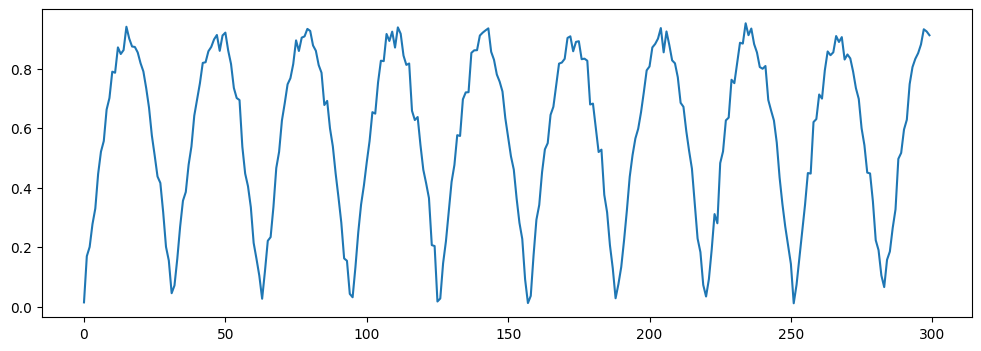

In [2]:
dataset = utils.SineDataset(lags=12)

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(dataset.data[:300].cpu())
plt.show()


In [3]:
class Model(nn.Module):

    def forward(self, x: torch.Tensor):
        y = self.model(x)
        return y.reshape(-1)

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            nn.LazyLinear(128),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),

            nn.LazyLinear(32),
            nn.LazyBatchNorm1d(),
            nn.Sigmoid(),

            nn.LazyLinear(1),
            nn.Sigmoid()
        )

In [4]:
lags = 12
batch_size = 256
epoch = 20

model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

losses = utils.fit(
    model=model,
    dataset=utils.SineDataset(lags),
    criterion=criterion,
    optimizer=optimizer,
    epoch=epoch,
    batch_size=batch_size,
    device=device,
    shuffle=True,
    progress=True,
    step_callback=None,
)

(20/20) | (39/39): 100%|██████████| 780/780 [00:04<00:00, 180.32it/s, loss=0.00133764] 


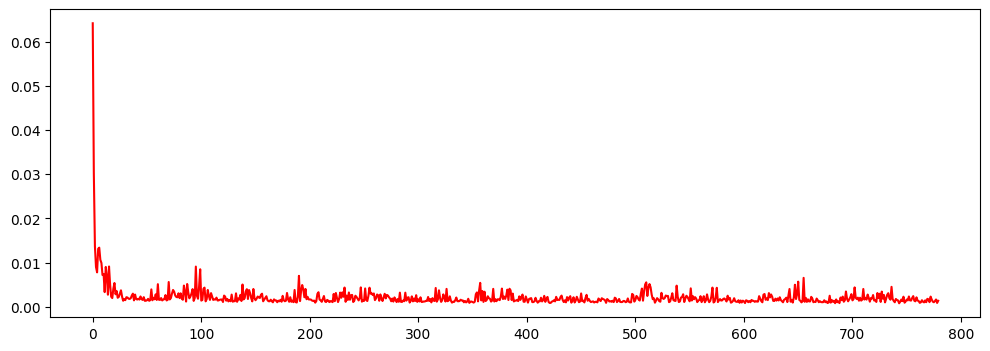

In [5]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(losses, 'r')
plt.show()
plt.close()

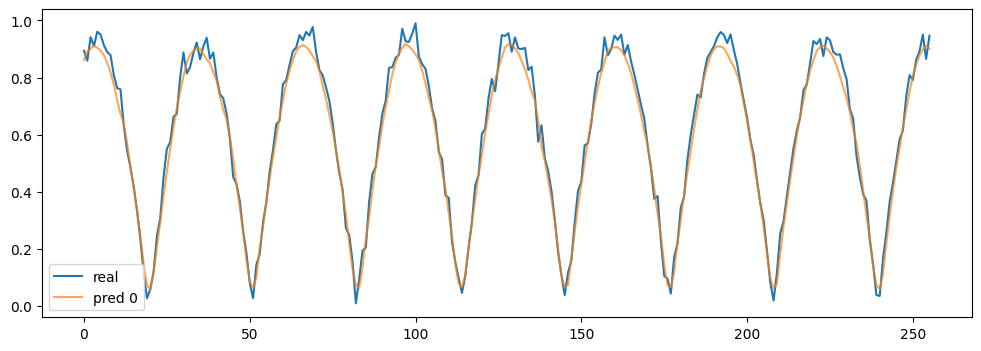

In [6]:
model.eval()
dataset = utils.SineDataset(lags, train=False, len=400)

real, preds = utils.test([model], dataset, batch_size, device, progress=False)


fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real.detach().cpu(), label='real')
for i, pred in enumerate(preds):
    ax.plot(pred.detach().cpu(), alpha=0.7, label=f'pred {i}')

plt.legend()
plt.show()
plt.close()